In [1]:
import pandas as pd
from simpleconjoint import cbc

## Reading and transforming dataframe

The csv data is a sample that contains a conjoint example about TVs, this data was recopilated in South America (that's why some column names are in Spanish).

<hr>

### Conjoint data:

Each Respondant had to answer 10 tasks with 5 alternative each.

`Num Encuestado` is the respondant id.
`Tarea` is the task or scenario number. 
`Alt` is to assign an alternative number.
``

Attributes: 
- Marca -> has 3 levels
- Sistema Operativo -> has 3 levels
- Tecnología -> has 2 levels
- Resolución -> has 5 levels
- Precio -> has 4 levels

This conjoint survey also had a no-choice alternative (column `None`)

<hr>

For version `0.0.1`, the cbc functions expect the following structure for the column names of attribute levels (covariates):
If it has more than one level: Attribute + _ + Level -> `Attribute_Level`
If it just the attribute/level itself: `Attribute`

For example, if your conjoint had the attribute `Color` with levels `Red`, `Green` and `Blue`, the columns for these could be -> `Color_Red`, `Color_Green` and `Color_Blue`

In [2]:
df = pd.read_excel("cbc_data.xlsx")
df

,Num Encuestado,Tarea,Alt,Marca,Sistema Operativo,Tecnología,Resolución,Precio,None,Seleccionada
0,2,1,1,A,A,A,C,D,0,0
1,2,1,2,C,B,A,A,A,0,0
2,2,1,3,B,C,B,B,A,0,0
3,2,1,4,B,B,B,E,C,0,0
4,2,1,5,NaN,NaN,NaN,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...
14995,324,10,1,C,B,B,A,A,0,0
14996,324,10,2,B,B,B,C,B,0,0
14997,324,10,3,B,C,A,D,C,0,1
14998,324,10,4,A,A,A,C,D,0,0


In [3]:
# Getting dummy variables (could be effect-coding/sum-to-zero too for hmnl)
df_dum = pd.get_dummies(df, columns=["Marca", "Sistema Operativo", "Tecnología", "Resolución", "Precio"])

# This data has NaN for the attribute columns on the no-choice alternative.
# Because columns (covariates/levels) aren't present for the no-choice column -> 0
df_dum = df_dum.fillna(0)
df_dum

,Num Encuestado,Tarea,Alt,None,Seleccionada,Marca_A,Marca_B,Marca_C,Sistema Operativo_A,Sistema Operativo_B,...,Tecnología_B,Resolución_A,Resolución_B,Resolución_C,Resolución_D,Resolución_E,Precio_A,Precio_B,Precio_C,Precio_D
0,2,1,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,2,1,2,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2,2,1,3,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,2,1,4,0,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
4,2,1,5,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,324,10,1,0,0,0,0,1,0,1,...,1,1,0,0,0,0,1,0,0,0
14996,324,10,2,0,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
14997,324,10,3,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
14998,324,10,4,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


## Count analysis

The `count()` function performs a simple analysis to "count" how many times the attribute levels or attribute level combinations were selected over the total appearances it had, returning a two dictionaries with dataframes.
- The first one is for the attributes sent (with attribute as keys).
- And the second one for the attribute combinations (with repr of attribute combinations as keys).

In choice-based conjoint, when an alternative is chosen/selected is set as `1`, `0` if it was not. For this reason, we need to know which dataframe column is for the chosen/selected alternatives -> `col_chosen` parameter, by default it goes with the column `Chosen`, for this example data, the column is `Seleccionada`

The `attribute` parameter expects a list with the attribute name, in this example it will be `Marca`, `Tecnología` and `Resolución`. It's an optional parameter.

The `attribute_combitations` parameter expects a list of lists, being each list the attribute combinations desired, for example: `[["Marca", "Precio"], ["Resolución", "Tecnología"]]`. It's an optional parameter.

You can also use the arg `to_excel=True` to save everything to a single excel named `Count_`+datetime`.xlsx`, having sheets for each attribute or attribute combinations

In [4]:
# Example variables mentioned before
col_chosen="Seleccionada"
attributes = ["Marca", "Tecnología", "Resolución"]
marca_precio = ["Marca", "Precio"]
resolucion_tecnologia = ["Resolución", "Tecnología"]
attribute_combinations = [marca_precio, resolucion_tecnologia]

# Calling the count analysis
count_attributes, count_combinations = cbc.count(
    df=df_dum,
    col_chosen=col_chosen,
    attributes=attributes,
    attribute_combinations=attribute_combinations
)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
df.columns

Index(['Num Encuestado', 'Tarea', 'Alt', 'Marca', 'Sistema Operativo',
       'Tecnología', 'Resolución', 'Precio', 'None', 'Seleccionada'],
      dtype='object')

### Count Analysis Results

As it was mentioned before, the count analysis returns 2 dictionaries with dataframes.
- count_attributes dictionary will have the attribute as keys, e.g: `count_attributes["Marca"]`
- count_combinations dictionary will have the list repr() as keys, e.g: `count_combinations[repr(marca_tecnologia)]`

Count Result is equal to `Times Chosen` / `Total Appearances`

In [6]:
count_attributes["Marca"]

,Attribute Level,Count Result,Times Chosen,Times Not Chosen,Total Appearances
0,Marca_A,0.21046,841.0,3155.0,3996.0
1,Marca_B,0.25999,1041.0,2963.0,4004.0
2,Marca_C,0.19600,784.0,3216.0,4000.0


In [7]:
count_attributes["Tecnología"]

,Attribute Level,Count Result,Times Chosen,Times Not Chosen,Total Appearances
0,Tecnología_A,0.224779,1348.0,4649.0,5997.0
1,Tecnología_B,0.219557,1318.0,4685.0,6003.0


In [8]:
count_combinations[repr(resolucion_tecnologia)]

,Count Result,Resolución,Tecnología,Times Chosen,Times Not Chosen,Total Appearances
0,0.212855,A,A,255.0,943.0,1198.0
1,0.235343,A,B,285.0,926.0,1211.0
2,0.247573,B,A,306.0,930.0,1236.0
3,0.247987,B,B,308.0,934.0,1242.0
4,0.259530,C,A,320.0,913.0,1233.0
5,0.250201,C,B,311.0,932.0,1243.0
6,0.196382,D,A,228.0,933.0,1161.0
7,0.160173,D,B,185.0,970.0,1155.0
8,0.204448,E,A,239.0,930.0,1169.0
9,0.198785,E,B,229.0,923.0,1152.0


## Hierarchical models

Everyone knows that different opinions are common between different individuals, meaning we can't expect multiple individuals to perform the same or choose the same product. 

In Non-Hierarchical models it is assumed that customer choices are probabilistic, meaning their actions are conditioned to probabilities per alternative.

On the other hand, Hierarchical models handle this problem by estimating the vector or part-worths per individual instead, that means each individual is considered unique, where percentages of his consumption will be assigned, based on his previous answers.

This is normally implemented by using bayesian inference and Markov Chain Monte Carlo (MCMC) algorithms for estimating priors and likelihood.
One of the most used hierarchical models is the HB or `Hierarchical Bayes` that's implemented by Sawtooth Software or the `Hierarchical Bayes Multinomial Logit` in ChoiceModelR.

### CBC Hierarchical Multinomial Logit model in simpleconjoint

The hmnl function in simpleconjoint uses the `pystan` package and the model proposed in the tutorial for R stan package: https://github.com/ksvanhorn/ART-Forum-2017-Stan-Tutorial

The model is the following:

```
data {
  int<lower=2> C; // # of alternatives (choices) in each scenario
  int<lower=1> K; // # of covariates of alternatives
  int<lower=1> R; // # of respondents
  int<lower=1> S; // # of scenarios per respondent
  int<lower=0> G; // # of respondent covariates 
  int<lower=1,upper=C> Y[R, S]; // observed choices
  matrix[C, K] X[R, S]; // matrix of attributes for each obs
  matrix[G, R] Z; // vector of covariates for each respondent
}

parameters {
  matrix[K, R] Beta;
  matrix[K, G] Theta;
  corr_matrix[K] Omega;
  vector<lower=0>[K] tau;
}
transformed parameters {
  cov_matrix[K] Sigma = quad_form_diag(Omega, tau);
}
model {
  //priors
  to_vector(Theta) ~ normal(0, 10);
  tau ~ cauchy(0, 2.5); 
  Omega ~ lkj_corr(2);
  //likelihood
  for (r in 1:R) {
    Beta[,r] ~ multi_normal(Theta*Z[,r], Sigma);	
    for (s in 1:S)
      Y[r,s] ~ categorical_logit(X[r,s]*Beta[,r]);
  }
}
```
How this model works:
- Beta is the vector with individual level part-worths / utilities to be estimated using a multivariate normal distribution: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
- Theta is the population means of part-worths with a normal distribution.
- tau is the variance vector of part-worths (on a cauchy distribution)
- Sigma is the covariance matrix: https://mc-stan.org/docs/2_18/stan-users-guide/multivariate-hierarchical-priors-section.html
> The function `quad_form_diag` is defined so that `quad_form_diag(Sigma, tau)` is equivalent to `diag_matrix(tau) * Sigma * diag_matrix(tau)`, where `diag_matrix(tau)` returns the matrix with tau on the diagonal and zeroes off diagonal.
- Omega is the correlation matrix (uses lkj_corr: https://mc-stan.org/docs/2_18/functions-reference/lkj-correlation.html)



![HMNL Bayesian Inference](https://raw.githubusercontent.com/ksvanhorn/ART-Forum-2017-Stan-Tutorial/master/3_hmnl/images/Bayesian_Inference.png)

### The hmnl() function

The hmnl() function expects a dataframe with the cbc data + extra configuration arguments (check function docstring for full description) and uses the `pystan` library (that does most of the job) with the Hierarchical Multinomial Logit model previously mentioned.

Since the choice based conjoint models compare the alternatives on each task based on the what were the choices the respondants made, to perform the cbc analysis we need to know which alternatives were present and what each respondant (by ids) chose on each task, meaning our dataframe should contain those columns too. These are the parameters that are used to know this columns:
- `col_resp_id` for the Respondant IDs column name
- `col_alt` for Alternatives column name
- `col_task` for the Task column name
- `col_chosen` for the Chosen column name

It also includes a parameter for the no-choice column name `col_none`, but for this model it's being estimated along with the other attribute levels, there are another ways and models used to separately estimate this no-choice alternative part-worth (and the idea is to implement them in future versions). 

Like it was mentioned before, hierarchical models work with a MCMC algorithm, so the function will need the amount of sampling iterations desired (the length of the chain) that are used for the stan model (hmnl model), the amount of samples used to reach convergence or to have sufficient precision may depend on the complexity of the data and model. Along with the iterations parameter, there are others that are used by the `pystan` library functions/classes:
- `iterations`: Integer. Amount of iterations or length of the chain, 2000 by default.
- `warmups`: Integer. Burn-in or throw in iterations. iterations//2 by default.
- `chains`: Positive integer specifying number of chains. 4 by default
- `algorithm`: String. One of the alogrithms that are implemented in the Stan library. "NUTS" by default. Possible ones : "HMC", "NUTS" and "Fixed_param".
- `seed`: The seed, a positive integer for random number generation. By default, seed is random.randint(0, MAX_UINT)
- `verbose`: bool. Indicates whether intermediate output should be piped to the console. False by default.
- `control` : dict, Optional. A dictionary of parameters to control the sampler's behavior.
- `n_jobs`: Integer. Sample in parallel. If -1 all CPUs are used. -1 by default.

For further explanation on the parameters read the pystan docs on the StanModel: https://pystan2.readthedocs.io/en/latest/_modules/pystan/model.html#StanModel 

Note: `n_jobs` should be <= `chains`, this is used to use cpus on multiple chains at the same time. Multithreading is an experimental feature on pystan 2.18+ so it's not enabled in the `hmnl()` function.

#### HMNL_Result object

The hmnl() function will return an `HMNL_Result` initialized object, having the following attributes:
- `stan_fit`: fit result of the hmnl model.
- `attributes`: conjoint attributes list 
- `covariates`: conjoint covariates list

To get the full result of this you should print the stan_fit attribute, e.g: if you saved the return in a variable named `result` -> `print(result.stan_fit)` will show the full summary.

To get the stan summary dict -> `result.summary`

To get the dataframe of the individual utilities -> `result.individual_utilities` or `result.get_individual_utilities()`

To get the dataframe of the individual importances -> `result.individual_importances` or `result.get_individual_importances()`

In [9]:
# Using the hmnl function with the example data:
# Number of iterations could be higher but remember this is just an example.

result = cbc.hmnl(
    df=df_dum,
    col_resp_id="Num Encuestado",
    col_task="Tarea",
    col_none="None",
    col_chosen="Seleccionada",
    iterations=1000,
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL HMNL_39a01ae177bc9856402f5ad061504c36 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
# getting pystan fit summary results
# The pystan fit betas (Beta[i, j]) are shown with i as the attribute level and j as the respondant
result.stan_fit


For the full summary use 'print(fit)'

Inference for Stan model: HMNL_39a01ae177bc9856402f5ad061504c36.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
Beta[1,1]     2.28    3.26   5.11   -7.55   -1.11   0.97   7.31  10.51      2   3.19
Beta[2,1]     0.43    1.36   2.53   -5.46   -1.29   1.55   1.86   3.81      3   1.82
Beta[3,1]   6.2e-3    1.27   2.26   -4.81   -1.49   0.17   1.46   4.05      3   1.88
Beta[4,1]     0.92    1.71   2.71   -2.67   -1.93   0.89   3.33   5.75      3   2.76
Beta[5,1]    -1.89     nan   2.41    -6.4   -3.31  -1.47  -1.15   3.11    nan   2.83
Beta[6,1]    -2.37    1.58   2.65    -7.6   -4.17   -1.7  -1.12   2.97      3   2.01
Beta[7,1]     1.07    1.47   2.38    -3.5   -0.08   0.52   2.26   6.45      3   2.42
Beta[8,1]     0.58    1.11   1.66   -2.75   -0.25   0.81   1.77   2.97      2   3.83
Beta[9,1]     

In [ ]:
# To check traceplots it's recommended to use arviz

# import arviz as az
# _ = az.plot_trace(result.stan_fit)

In [11]:
# The pystan fit also contains the numpy array of betas, thetas, omegas, taus and sigmas that each chain got.

betas = result.stan_fit["Beta"] # same with "Theta", "tau", "Omega" and "Sigma"
betas

array([[[ -1.05695708,  -9.7073147 ,  -3.41543236, ...,  -8.68517242,
          -3.97030666,  -1.4675079 ],
        [ -5.49336421,  -5.09096288,  -3.92325459, ...,  -4.68468849,
          -4.30546412,  -4.01920645],
        [ -4.96667617,  -5.02791566,  -2.65460919, ...,  -4.54624954,
          -4.09452451,  -2.56156998],
        ...,
        [ -0.59721382,  -0.29027712,  -1.16062788, ...,  -1.04794608,
          -0.07701795,   0.5596572 ],
        [ -1.22669978,  -0.26296277,  -1.03459069, ...,  -0.75083405,
          -1.19144112,  -0.84851918],
        [ -0.38531681,  -1.18707726,  -0.75344776, ...,   0.28125201,
          -2.07922848,  -1.722467  ]],

       [[  4.29321943,  -1.3628318 ,   1.19747343, ...,  -4.14644674,
          -1.36733964,  -0.57651885],
        [ -2.59765287,  -3.3493675 ,  -0.90445017, ...,  -3.24390756,
          -0.22149768,  -1.31162313],
        [ -3.69484837,  -2.38185324,  -3.36753551, ...,  -1.28456735,
          -2.92763547,  -0.72088955],
        ...,


In [12]:
# pystan summary dictionaries (contains multiple dictionaries with the info shown using print(result.stan_fit))
result.summary

OrderedDict([('summary',
              array([[ 2.27909200e+00,  3.26093881e+00,  5.11358679e+00, ...,
                       1.05114116e+01,  2.45904210e+00,  3.18537293e+00],
                     [ 4.26376967e-01,  1.36007840e+00,  2.53364996e+00, ...,
                       3.81174993e+00,  3.47028658e+00,  1.81776225e+00],
                     [ 6.24353393e-03,  1.27431518e+00,  2.26248900e+00, ...,
                       4.05442257e+00,  3.15223974e+00,  1.87920448e+00],
                     ...,
                     [ 2.60845088e-01,  9.72444725e-02,  2.49228578e-01, ...,
                       8.19846355e-01,  6.56849435e+00,  1.59424705e+00],
                     [ 2.06412478e+00,  1.17877223e+00,  1.71778165e+00, ...,
                       4.93059110e+00,  2.12361666e+00,  4.83606553e+00],
                     [-5.66270440e+15,  6.93363324e+15,  9.81054467e+15, ...,
                      -1.05840667e+03,  2.00200200e+00,  3.71448514e+13]])),
             ('c_summary',
       

In [13]:
# Getting individual utilities dataframe:
result.individual_utilities

,None,Marca_A,Marca_B,Marca_C,Sistema Operativo_A,Sistema Operativo_B,Sistema Operativo_C,Tecnología_A,Tecnología_B,Resolución_A,Resolución_B,Resolución_C,Resolución_D,Resolución_E,Precio_A,Precio_B,Precio_C,Precio_D
0,2.279092,0.426377,0.006244,0.922545,-1.890563,-2.368227,1.069396,0.583531,0.098893,-0.842860,-0.607190,-0.374097,-0.634628,-0.692958,-0.862583,-0.193813,-0.497710,-0.967100
1,-4.337165,-0.116939,-0.280050,1.386940,-0.749443,0.312886,-0.910435,0.442232,0.235909,-0.416865,-0.609918,-0.012996,0.103529,-0.062686,-0.961906,0.054516,-0.369851,0.193197
2,-0.230925,0.767191,0.592807,1.116732,-0.744692,-2.721896,0.786022,0.465810,0.643842,-1.075907,-0.510572,-0.656211,-0.557012,-0.598236,0.960784,-0.532918,-0.180688,-1.217084
3,-5.584822,1.332660,2.319675,0.406453,0.060092,-2.610694,-1.748734,0.484685,0.192969,0.224130,-0.368023,0.132028,-0.815092,-0.749329,0.824820,0.453130,-0.947487,-0.831935
4,-0.536983,1.187892,0.667756,0.689390,-1.294540,-1.981646,0.094285,0.796828,0.110270,-0.713835,-0.393864,-0.373866,-0.660354,-0.777513,-0.958736,0.064281,-0.622054,-0.863239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-4.423703,1.969718,0.549094,0.621545,-0.722712,0.726941,-1.169994,0.313139,0.285096,-0.647920,-0.301484,-0.793803,-0.909116,-0.799632,1.415503,0.516812,-0.541671,-1.471679
296,-4.100849,2.096218,1.711476,0.577136,-1.181914,-2.674760,0.242464,0.539501,0.878301,-1.280613,-0.687422,0.025942,-0.868274,-1.107500,0.584506,-0.135218,-0.708023,-0.823405
297,-6.321779,0.835850,0.406152,0.499469,-0.061745,0.101718,-1.453632,0.162547,-0.125719,-0.195649,-0.730045,-0.195453,-0.434089,-0.235467,-0.286061,-0.636671,0.057908,-0.048077
298,-3.074186,1.783106,-0.105316,1.550968,-0.494853,-1.597389,0.413533,0.314642,-0.088891,-0.645366,-0.275802,-0.322382,-0.942543,-1.108580,1.219127,0.904874,-0.001456,-1.716130


In [14]:
# Getting individual importances dataframe:
result.individual_importances

,Precio,Sistema Operativo,Marca,Resolución,Tecnología
0,0.127172,0.565342,0.150692,0.077091,0.079702
1,0.232641,0.246380,0.335736,0.143690,0.041554
2,0.313224,0.504513,0.075351,0.081307,0.025605
3,0.230551,0.347431,0.248882,0.135188,0.037948
4,0.217234,0.440816,0.110449,0.085713,0.145788
...,...,...,...,...,...
295,0.422077,0.277313,0.207681,0.088830,0.004100
296,0.187983,0.389505,0.202826,0.174450,0.045236
297,0.198310,0.444071,0.122684,0.152632,0.082303
298,0.363683,0.249157,0.233979,0.103183,0.049999


In [15]:
# If you want to get the attribute importances -> it's always the mean of the individual_importances
result.individual_importances.mean()

Precio               0.272305
Sistema Operativo    0.267795
Marca                0.222498
Resolución           0.172073
Tecnología           0.065329
dtype: float64

### Simulating scenario share of preference with individual utilities for HMNL_Result

You can also simulate the share of preferences for an scenario with the method `simulate_share_of_preference(scenario)` where `scenario` is the simulated scenario dataframe. This simulation is done by calculating getting the probability of each alternative for each individual then getting the average.

For each individual the probability of an alternative is calculated with the multinomial logit formula:
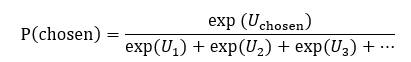

Where `U` is the total utility for that alternative (sum of each utility for the level present in the alternative).

In [16]:
# Estimating share of preference of an scenario
# For example let's take the first 3 alternatives of the firt participant

scenario = df_dum.iloc[:3]
scenario = scenario.drop(columns=["Num Encuestado", "Tarea", "Alt", "Seleccionada"])
scenario

,None,Marca_A,Marca_B,Marca_C,Sistema Operativo_A,Sistema Operativo_B,Sistema Operativo_C,Tecnología_A,Tecnología_B,Resolución_A,Resolución_B,Resolución_C,Resolución_D,Resolución_E,Precio_A,Precio_B,Precio_C,Precio_D
0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0


In [17]:
scenario_simulation = result.simulate_share_of_preference(scenario=scenario)
scenario_simulation

,None,Marca_A,Marca_B,Marca_C,Sistema Operativo_A,Sistema Operativo_B,Sistema Operativo_C,Tecnología_A,Tecnología_B,Resolución_A,Resolución_B,Resolución_C,Resolución_D,Resolución_E,Precio_A,Precio_B,Precio_C,Precio_D,Exp(Utility),ShareOP
0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,64.814791,0.216049
1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,61.838957,0.206130
2,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,173.346253,0.577821


In [18]:
scenario_simulation["ShareOP"]

0    0.216049
1    0.206130
2    0.577821
Name: ShareOP, dtype: float64